In [1]:
import pandas as pd

df = pd.read_csv('../data/df.csv')

In [2]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        folder_name = self.df['folder'][idx]
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + folder_name + '/' + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [4]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("trocr-base-handwritten")
train_dataset = IAMDataset(root_dir='../session_12_Group_Work/',
                           df=train_df,
                           processor=processor)
eval_dataset = IAMDataset(root_dir='../',
                           df=test_df,
                           processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3520
Number of validation examples: 880


In [6]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([3583])


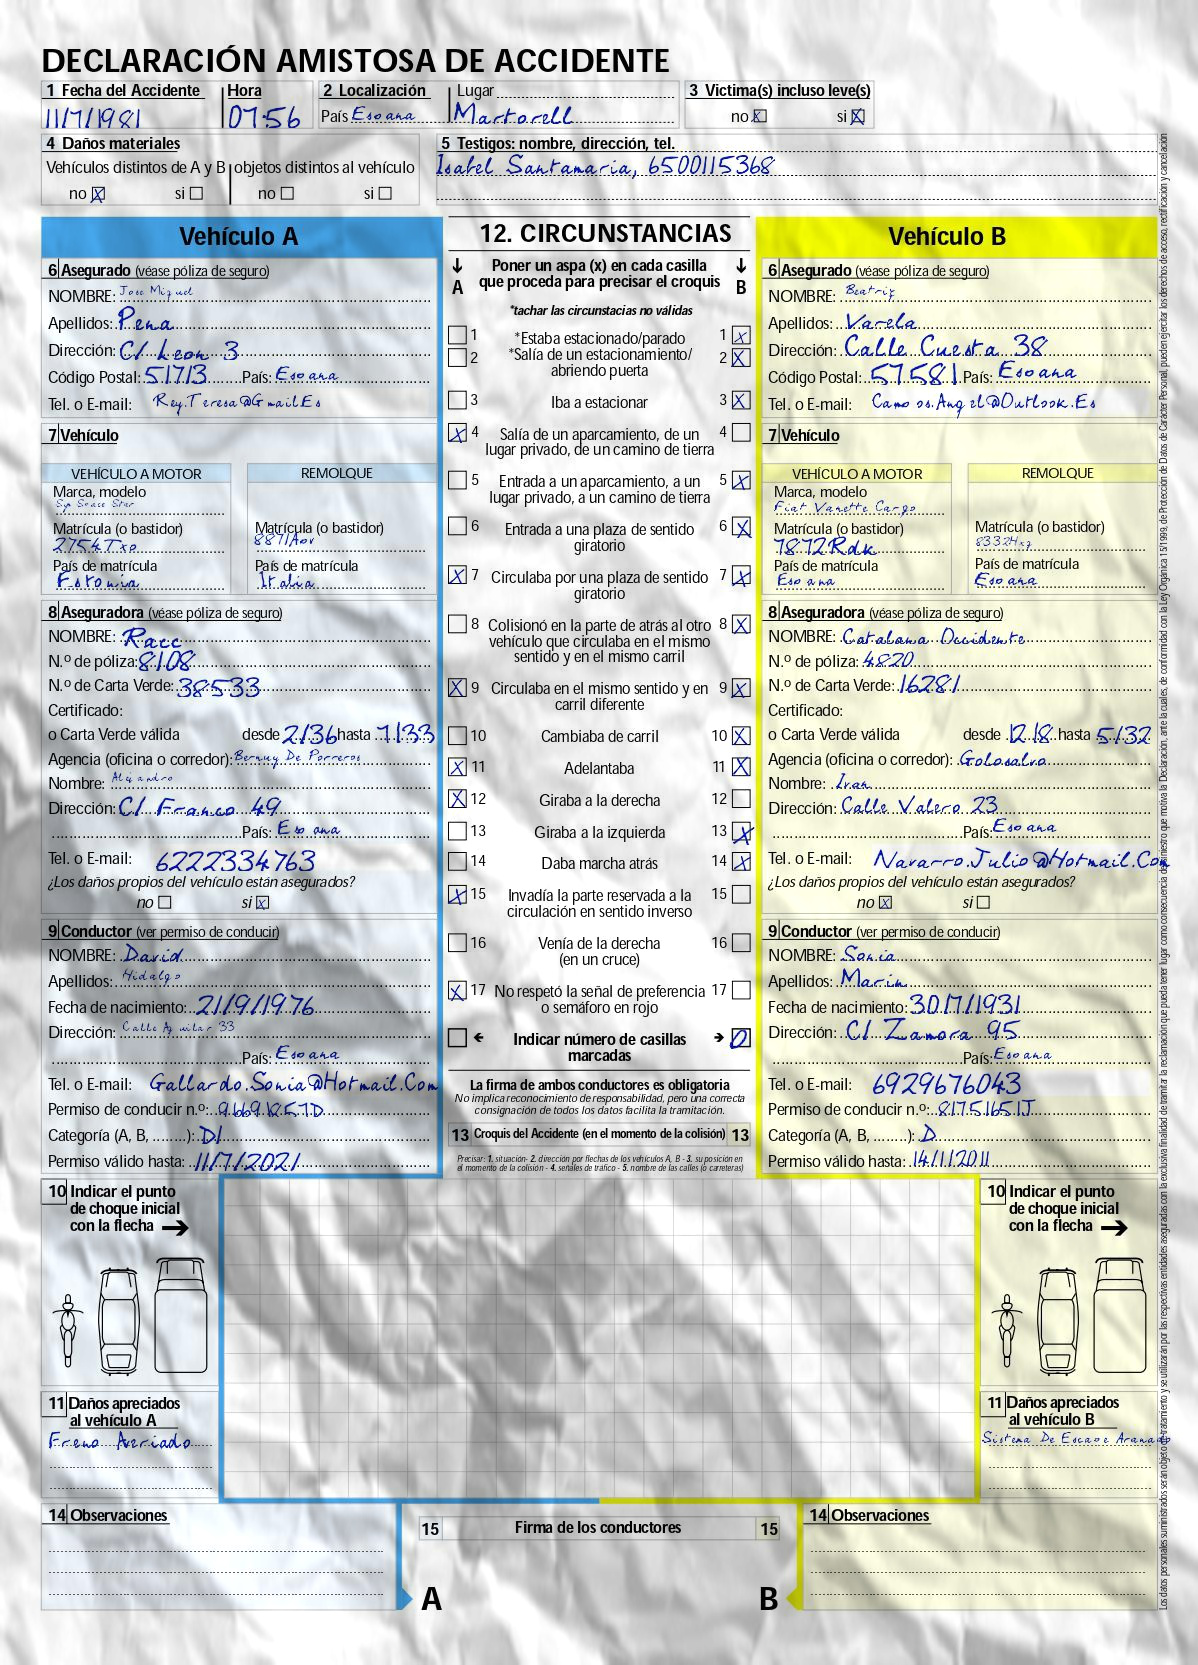

In [7]:
image = Image.open(train_dataset.root_dir + train_df['folder'][0] + '/' + train_df['file_name'][0]).convert("RGB")
image

In [8]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

campo x y w h textfecha 42 106 97 21 11/7/1981hora 224 104 76 23 07:56localizacion pais 352 106 63 13 Espanadanos_materiales objetos si 378 191 0 0  danos_materiales vehículos no 89 187 15 15 Xlugar 453 101 119 22 Martorellvictimas si 848 107 16 17 Xtestigos 436 153 339 25 Isabel Santamaria, 6500115368A asegurado nombre 118 284 75 16 Jose MiguelA asegurado apellidos 115 305 58 24 PenaA asegurado direccion 118 338 120 21 C/ Leon 3A asegurado codigo_postal 143 363 63 20 51713A asegurado pais 275 365 63 14 EspanaA asegurado telefono 151 392 169 23 Rey.Teresa@Gmail.EsA  vehiculo marca_modelo 54 498 80 14 Sym Space StarA  vehiculo matricula 53 537 83 13 2754TxoA  vehiculo pais 53 570 86 16 EstoniaA  remolque matricula 253 532 61 14 8871ApvA  remolque pais 256 570 58 16 ItaliaA  aseguradora_nombre 118 627 63 20 RaccA  aseguradora num_poliza 138 650 57 20 8108A  aseguradora carta_verde 175 676 85 20 38533A  aseguradora carta_verde_desde 282 723 55 20 2/36A  aseguradora carta_verde_hasta 372 7

In [9]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("trocr-base-stage1")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [11]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [12]:
from datasets import load_metric

cer_metric = load_metric("cer")

C:\Users\tonyf\AppData\Local\Temp\ipykernel_7232\152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [13]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [14]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

c:\Users\tonyf\anaconda3\lib\site-packages\transformers\models\trocr\processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
c:\Users\tonyf\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1320 [00:00<?, ?it/s]

RuntimeError: stack expects each tensor to be equal size, but got [3597] at entry 0 and [3674] at entry 1